In [1]:
import librosa
import librosa.display
import tensorflow as tf
import kapre
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import pathlib
import os
import glob
import random
import math 
import soundfile as sf
import librosa 
from plotnine import *
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
import seaborn as sn
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.utils import shuffle
from tqdm.notebook import trange, tqdm
import tensorflow.keras.backend as K

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [3]:
seed = 27
tf.random.set_seed(seed)
random.seed(seed)
gpus = tf.config.list_physical_devices('GPU')

## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [4]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train/'
audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

# Meta Data

In [26]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta.ID = meta.ID.str.strip()

In [6]:
meta.sample(5)

,index,ID,Age,Gender,MMSE,Group
71,17,S101,56,female,24,cd
25,25,S033,61,female,30,cc
24,24,S032,57,female,28,cc
58,4,S083,52,male,30,cd
3,3,S004,71,female,30,cc


# Baseline 

In [7]:
filenames = list(glob.glob('/tf/data/dementia/0extra/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/*/*'))
random.shuffle(filenames)

In [8]:
def getMelSpectrogramSamples(filename, n_mels=128, fmin=20, fmax=8000):
    y, sr = librosa.load(filename)

    ps = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax, power=2)
    S_dB = librosa.power_to_db(ps, ref=np.max)
    
    #15 seconds
    window_size = 640
    window_hop = 160

    # truncate at start and end to only have windows full data
    # alternative would be to zero-pad
    start_frame = window_size 
    end_frame = window_hop * math.floor(float(S_dB.shape[1]) / window_hop)

    samples = np.array([S_dB[:, frame_idx-window_size:frame_idx] for frame_idx in range(start_frame, end_frame, window_hop)])
    
    return samples

def getSpectrogramSamples(filename):
    y, sr = librosa.load(filename)
    S = np.abs(librosa.stft(y, n_fft=512))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)
    
    #15 seconds
    window_size = 640
    window_hop = 20

    # truncate at start and end to only have windows full data
    # alternative would be to zero-pad
    start_frame = window_size 
    end_frame = window_hop * math.floor(float(S_dB.shape[1]) / window_hop)

    samples = np.array([S_dB[:, frame_idx-window_size:frame_idx] for frame_idx in range(start_frame, end_frame, window_hop)])
    
    return samples

In [9]:
allSamples = []
ids = np.array([])
mmse_scores = np.array([])
classes = np.array([])

for file in tqdm(filenames):
    id = file.split('/')[-1].split('.')[0]
    mmse = meta.loc[meta.ID==id,"MMSE"].values[0]
    group = meta.loc[meta.ID==id,"Group"].values[0]
    
    samples = getMelSpectrogramSamples(file)
    allSamples.append(samples)
    
    numSamples = samples.shape[0]
    
    ids = np.append(ids, np.repeat(int(id[1:]), numSamples))
    mmse_scores = np.append(mmse_scores, np.repeat(mmse, numSamples))
    classes = np.append(classes, np.repeat(group, numSamples))

In [10]:
X = np.expand_dims(np.vstack(allSamples), -1)
y = mmse_scores

In [11]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, groups=ids)

5

In [12]:
train_index, test_index = next(group_kfold.split(X, y, groups=ids))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]
ids_train, ids_test = ids[train_index], ids[test_index]

X_train, y_train, ids_train = shuffle(X_train, y_train, ids_train)
X_test, y_test, ids_test = shuffle(X_test, y_test, ids_test)

In [13]:
train_segment_mapping = {id:i for i, id in enumerate(np.unique(ids_train))}
segments_train = np.array([train_segment_mapping[id] for id in ids_train])

test_segment_mapping = {id:i for i, id in enumerate(np.unique(ids_test))}
segments_test = np.array([test_segment_mapping[id] for id in ids_test])

In [14]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(SquareRootScheduler(lr=0.001))

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=10, 
    restore_best_weights=True)

In [15]:
def CustomWeightedLoss(y_true, y_pred, segments):
    
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    segments = tf.cast(segments,tf.int32)
        
    grouped_y_true = tf.math.unsorted_segment_mean(
        y_true, segments, 1000
    )

    grouped_y_pred = tf.math.unsorted_segment_mean(
        y_pred, segments, 1000
    )

    # this returns the sum of squared errors across all samples. 
    # to find the actual RMSE, use this: lambda x: sqrt(X/num_samples)
    return tf.reduce_sum(tf.math.square(grouped_y_pred - grouped_y_true), axis=-1)

In [16]:
inp = layers.Input(X.shape[1:])
true = layers.Input((1))
segment = layers.Input((1))

conv1 = layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='conv1')(inp)
pool1 = layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool1')(conv1)
flatten = layers.Flatten()(pool1)

dense1 = layers.Dense(128, activation='relu')(flatten)
dropout1 = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(32, activation='relu')(dropout1)
dropout2 = layers.Dropout(0.5)(dense2)
out = layers.Dense(1)(dropout2)

    
model = tf.keras.Model([inp, true, segment], out)

model.add_loss(CustomWeightedLoss(true, out, segment) )

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss=None
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 640, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 640, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 320, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 655360)       0           pool1[0][0]                      
______________________________________________________________________________________________

In [18]:
history = model.fit(
    [X_train, y_train, segments_train], 
    y_train, 
    epochs=1000, 
    batch_size=64,
    verbose=1,
    callbacks = [es_callback, lr_callback]
)

Epoch 1/1000
21/21 [==============================] - 14s 653ms/step - loss: 159626714.1850
Epoch 2/1000
21/21 [==============================] - 17s 813ms/step - loss: 30765.7874
Epoch 3/1000
21/21 [==============================] - 18s 835ms/step - loss: 18563.1764
Epoch 4/1000
21/21 [==============================] - 18s 834ms/step - loss: 21365.0891
Epoch 5/1000
21/21 [==============================] - 18s 845ms/step - loss: 15018.3768
Epoch 6/1000
21/21 [==============================] - 18s 841ms/step - loss: 13099.8108
Epoch 7/1000
21/21 [==============================] - 18s 855ms/step - loss: 12744.5562
Epoch 8/1000
21/21 [==============================] - 18s 856ms/step - loss: 13093.4456
Epoch 9/1000
21/21 [==============================] - 18s 847ms/step - loss: 10592.5038
Epoch 10/1000
21/21 [==============================] - 18s 860ms/step - loss: 10816.3536
Epoch 11/1000
21/21 [==============================] - 18s 850ms/step - loss: 9043.0554
Epoch 12/1000
21/21 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


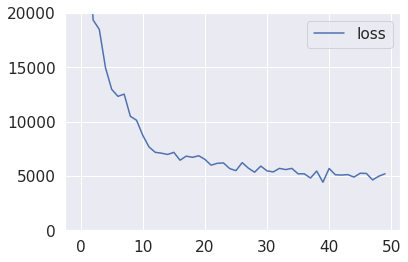

In [61]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
axes = plt.axes()
axes.set_ylim([0, 20000])
plt.show()

In [19]:
def evaluateRMSE(model, X, y, segments):
    return np.sqrt(model.evaluate([X,y,segments],y)/len(np.unique(segments)))

In [20]:
evaluateRMSE(model, X_train, y_train, segments_train)

41/41 [==============================] - 5s 120ms/step - loss: 2529.8127


5.3924305655163725

In [21]:
evaluateRMSE(model, X_test, y_test, segments_test)

11/11 [==============================] - 1s 126ms/step - loss: 1681.6367


8.948627771233712

# Inference 

In [ ]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in tqdm(filenames):
    id = file.split('/')[-1].split('.')[0]
    mmse = meta.loc[meta.ID==id,"MMSE"].values[0]
    group = meta.loc[meta.ID==id,"Group"].values[0]
    
    samples = getMelSpectrogramSamples(file)
    predict = model.predict([samples, np.zeros(len(samples)), np.zeros(len(samples))]).flatten().mean()
    meta.at[np.where(meta.ID == (id))[0][0], 'predict'] = max(1, min(predict, 30))
    if (predict < 24):
        meta.at[np.where(meta.ID == (id))[0][0], 'predict_group'] = 'cd'

In [41]:
meta.predict.describe()

count    108.000000
mean      13.878784
std        2.491499
min        8.044751
25%       12.023446
50%       13.950255
75%       16.237095
max       18.499434
Name: predict, dtype: float64

In [42]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

10.60644077165574

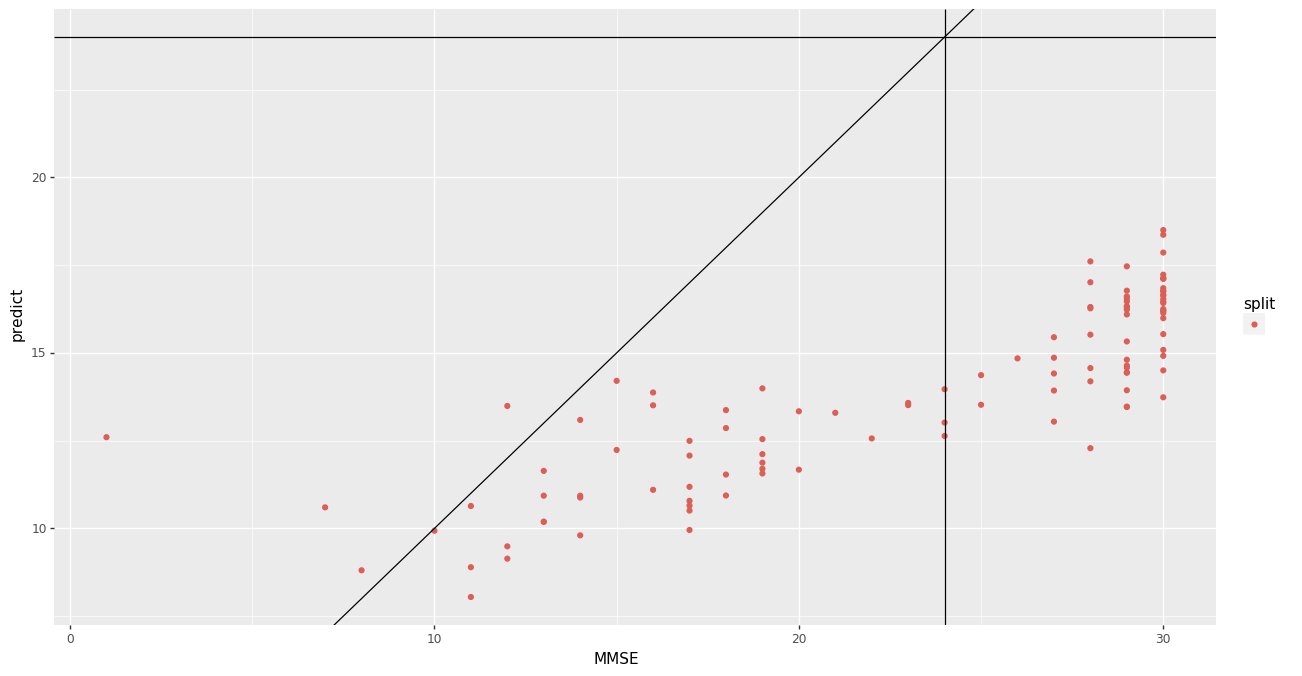

<ggplot: (-9223363281593256013)>

In [43]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

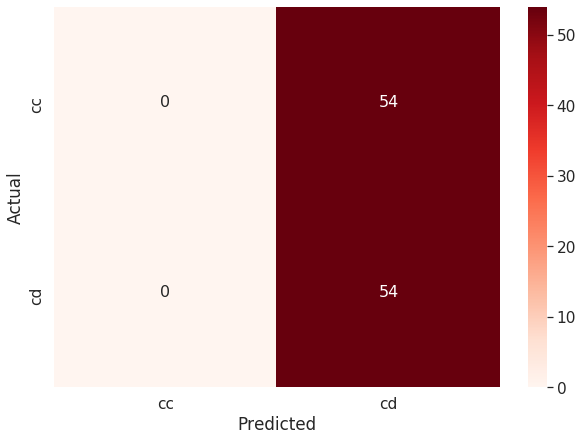

In [44]:
y_true = meta.Group
y_pred = meta.predict_group
data_c = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data_c, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

# Pitts Corpus

In [45]:
data_path_pitt = '/tf/data/dementia/English/Pitt/'
files_pitt = tf.io.gfile.glob(data_path_pitt + 'Control/cookie/*.wav') + \
             tf.io.gfile.glob(data_path_pitt + 'Dementia/cookie/*.wav')

In [48]:
meta_pitt = pd.DataFrame(columns= ['file', 'ID', 'Group', 'MMSE', 'predict', 'predict_group'])
for file in tqdm(files_pitt):
#     print(file)
    ID = file.split('/')[-1].split('.')[0]
    Group = file.split('/')[6]
    cha = pd.read_fwf(data_path_pitt + 'Pitt/' + Group + '/cookie/' + ID + '.cha')  
    cha_id = [x for x in cha['@UTF8'] if str.startswith(x, '@ID:')][0]
    
    if (cha_id.split('|')[-3] == ''):
        MMSE = np.NaN
    else:
        MMSE = int(cha_id.split('|')[-3])
        
    samples = getMelSpectrogramSamples(file)
    if len(samples) == 0:
        predict = np.nan
    else:
        predict = model.predict([samples, np.zeros(len(samples)), np.zeros(len(samples))]).flatten().mean()
        predict = max(1, min(predict, 30))
            
    if (predict < 24):
        predict_group = 'Dementia'
    else:
        predict_group = 'Control'
        
    meta_pitt = meta_pitt.append(pd.DataFrame([[file, ID, Group, MMSE, predict, predict_group]], 
                                  columns = list(meta_pitt.columns)))

In [49]:
meta_pitt['predict'].describe()

count    550.000000
mean      11.731840
std        1.358399
min        8.093636
25%       10.756529
50%       11.609234
75%       12.620004
max       16.568659
Name: predict, dtype: float64

In [50]:
meta_pitt_eval = meta_pitt[meta_pitt.MMSE.notna()]

In [51]:
meta_pitt.shape

(552, 6)

In [52]:


meta_pitt_eval.shape

(457, 6)

In [53]:
meta_pitt_eval.head()sssssdddd

SyntaxError: invalid syntax (<ipython-input-53-78268038d28a>, line 1)

In [ ]:
y_true = meta_pitt.Group
y_pred = meta_pitt.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16})# font size